In [6]:
# Packages
library(caret)
library(tidyverse)
library(janitor)
library(randomForest)
library(gbm)
library(flextable)


In [7]:
# Load data
dataset_math_perform  <- read.csv("../../../data/clean_data_student_math_performance.csv", 
                                      header=TRUE) 

In [8]:
math_performance  <- 
  dataset_math_perform %>% 
    dplyr::select(-c(g3,X)) %>% 
        
        # Transform variables to numeric
        mutate(g3_binary = factor(g3_binary),
               g2 = as.integer(g2),
               g1 = as.integer(g1),
               absences = as.integer(absences)) %>%
        # Transform chr type to factor
        mutate(across(where(is.character), as.factor))

# Split data into training and testing

In [9]:
set.seed(999)
# slip data into train and test

# Get index
train_index <- sample(1:nrow(math_performance ),
                      (nrow(math_performance )*75)/100)

# Train set
math_performance_train <- math_performance[train_index,]

# Test set
math_performance_test <- math_performance[-train_index,]


In [10]:
# First, we set up the cross validation control
# Setting up the k-fold cross validation k = 10 cross-validation folds.

#Setting the random seed for replication
set.seed(999)

#setting up cross-validation
cvcontrol <- trainControl(method = "repeatedcv", 
                          number = 10,
                          allowParallel = TRUE)

# Classification Tree

In [11]:
train_tree <- train(g3_binary ~ ., 
                   data = math_performance_train,
                   method = "ctree",
                   trControl = cvcontrol,
                   tuneLength = 5)

In [12]:
# obtaining class predictions
tree_class_test <-  predict(train_tree,
                            newdata = math_performance_test, 
                            type = "raw")

In [13]:
descision_tree_stats <- confusionMatrix(math_performance_test$g3_binary,
                                        tree_class_test,positive = "pass" )

decision_table <- 
    rbind(as.data.frame(descision_tree_stats[3]) %>%
            rownames_to_column("var") %>% 
            rename(value = "overall") %>% 
            filter(var %in% c("Accuracy","AccuracyLower","AccuracyUpper")),
            
          as.data.frame(descision_tree_stats[4]) %>% 
            rownames_to_column("var")  %>%
            rename(value = "byClass") %>%
            filter(var %in% c("Sensitivity","Specificity"))) %>%
      
    mutate(model = factor(rep("decision_tree", nrow(.))))

# Bagging of ctrees

In [14]:
#Using treebag 
train_bagg <- train(g3_binary  ~ ., 
                   data = math_performance_train,
                   method = "treebag",
                   trControl = cvcontrol,
                   importance = TRUE,
                   tuneLength = 5,)

In [15]:
bagg_class_test <- predict(train_bagg, 
                          newdata = math_performance_test,
                          type="raw")

In [16]:
bagging_stats <- confusionMatrix(math_performance_test$g3_binary, bagg_class_test,
                                 positive = "pass")

bagging_table <- 
  rbind(as.data.frame(bagging_stats[3]) %>% 
          rownames_to_column("var") %>% 
          rename(value = "overall") %>% 
          filter(var %in% c("Accuracy","AccuracyLower","AccuracyUpper")),
            
        as.data.frame(bagging_stats[4]) %>% 
          rownames_to_column("var")  %>%
          rename(value = "byClass") %>%
          filter(var %in% c("Sensitivity","Specificity"))) %>% 
  mutate(model = factor(rep("bagging_tree", nrow(.))))

In [17]:
# Random Forest for classification trees

In [18]:
#Using treebag 
train_random_forest <- train(g3_binary  ~ ., 
                             data = math_performance_train,
                             method = "rf",
                             trControl = cvcontrol,
                             importance = TRUE)

In [19]:
#obtaining class predictions
rf_class_test <- predict(train_random_forest, 
                         newdata = math_performance_test,
                          type="raw")

In [20]:
random_forest_stats <- confusionMatrix(math_performance_test$g3_binary,rf_class_test,
                positive = "pass" )

rf_table <- 
  rbind(as.data.frame(random_forest_stats[3]) %>% 
        rownames_to_column("var") %>% 
        rename(value = "overall") %>% 
        filter(var %in% c("Accuracy","AccuracyLower","AccuracyUpper")),
          
      as.data.frame(random_forest_stats[4]) %>% 
        rownames_to_column("var")  %>%
        rename(value = "byClass") %>%
        filter(var %in% c("Sensitivity","Specificity"))) %>% 
  mutate(model = factor(rep("random_forest", nrow(.))))

# Random Forest with Gradient Boosting

In [21]:
train_gbm <- train(g3_binary ~ ., 
                   data = math_performance_train,
                   method="gbm",
                   
                   verbose = F,
                   trControl=cvcontrol)

In [22]:
#obtaining class predictions
gbm_class_test <-  predict(train_gbm,
                           newdata = math_performance_test,
                           type = "raw",
                           importance = T)

In [23]:
#computing confusion matrix
random_rorest_gradient_boosting_stats <- confusionMatrix(math_performance_test$g3_binary,
                                                   gbm_class_test,
                                                   positive = "pass" )

rf_gradient_boosting_table <- 
          rbind(as.data.frame(random_rorest_gradient_boosting_stats[3]) %>% 
                  rownames_to_column("var") %>% 
                  rename(value = "overall") %>% 
                  filter(var %in% c("Accuracy","AccuracyLower","AccuracyUpper")),
                    
                as.data.frame(random_rorest_gradient_boosting_stats[4]) %>% 
                  rownames_to_column("var")  %>%
                  rename(value = "byClass") %>%
                  filter(var %in% c("Sensitivity","Specificity"))) %>% 
          mutate(model = factor(rep("random_rorest_gradient_boosting",nrow(.))))

# kNN

In [24]:
knn_pred_caret <- train(g3_binary ~ .,
                        math_performance_train,
                        method = "knn",
                        preProcess = c("center","scale"))


In [25]:
knn_predict <- predict(knn_pred_caret, newdata = math_performance_test)

In [26]:
knn_stats <- confusionMatrix(knn_predict, math_performance_test$g3_binary, 
                positive = "pass")

knn_table <- 
      rbind(as.data.frame(knn_stats[3]) %>% 
              rownames_to_column("var") %>% 
              rename(value = "overall") %>% 
              filter(var %in% c("Accuracy","AccuracyLower","AccuracyUpper")),
          
            as.data.frame(knn_stats[4]) %>% 
              rownames_to_column("var")  %>%
              rename(value = "byClass") %>%
              filter(var %in% c("Sensitivity","Specificity"))) %>% 
      mutate(model = factor(rep("knn", nrow(.))))

# Figure 5

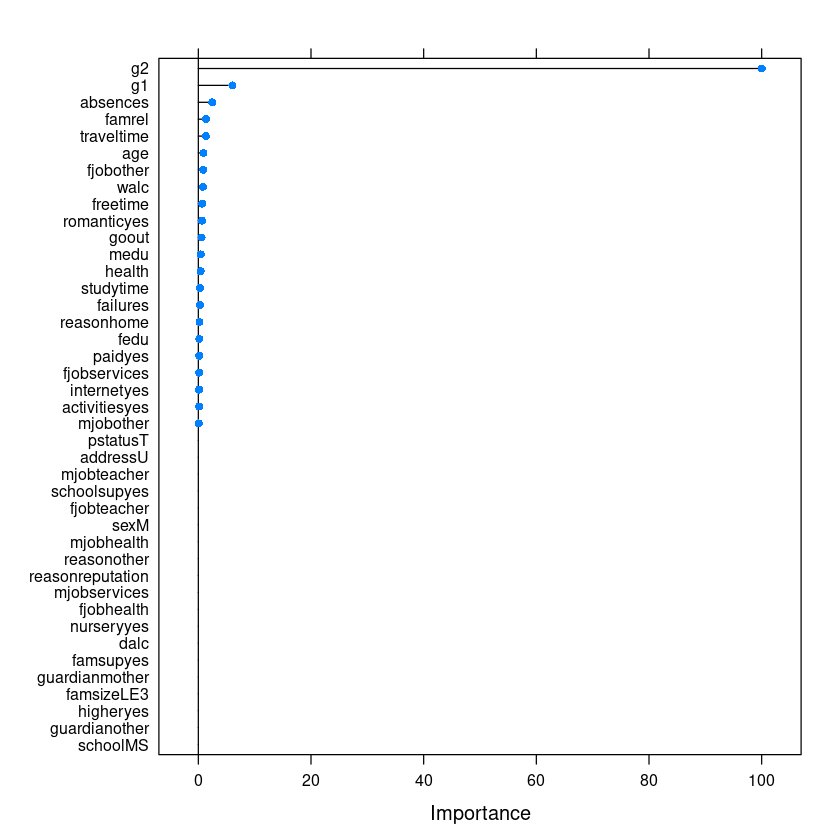

In [27]:
plot(varImp(train_gbm))

# Table 5

In [28]:
(table_5 <- rbind(decision_table, bagging_table, rf_table,
            rf_gradient_boosting_table, knn_table) %>% 
    pivot_wider(names_from = var, values_from = value) %>% 
  flextable())


a flextable object.
col_keys: `model`, `Accuracy`, `AccuracyLower`, `AccuracyUpper`, `Sensitivity`, `Specificity` 
header has 1 row(s) 
body has 5 row(s) 
original dataset sample: 
                            model  Accuracy AccuracyLower AccuracyUpper
1                   decision_tree 0.8989899     0.8220754     0.9504891
2                    bagging_tree 0.9090909     0.8344310     0.9575835
3                   random_forest 0.9090909     0.8344310     0.9575835
4 random_rorest_gradient_boosting 0.9191919     0.8469730     0.9644665
5                             knn 0.7373737     0.6393278     0.8207276
  Sensitivity Specificity
1   0.8714286   0.9655172
2   0.8955224   0.9375000
3   0.8840580   0.9666667
4   0.9090909   0.9393939
5   0.9354839   0.4054054